In [89]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeRegressor


class BoostingRegressorDIY(BaseEstimator, RegressorMixin):
    def __init__(self, max_depth, n_estimators=100, learning_rate=0.01, gamma=0.01):

        self.max_depth = max_depth

        self.n_estimators = n_estimators
        self.learning_rate = learning_rate

        self.trees = []
        self.y_base = 0
        self.y_pred = 0

        self.gamma = gamma

    @staticmethod
    def loss(y_true, y_pred):
        return y_true - y_pred

    def regularization(self, tree):
        """
        Будем штрафовать нашу модель за количество листьев. Смысл простой: чем больше листьев, тем лучше модель запоминает данные (т.е. переобучается) и тем ниже ее обобщающая способность. Поэтому будем немного "портить" предсказываемые значения, чтобы модель хуже запоминала данные. И чем больше листьев будет в модели тем сильнее будет это влияние.
        """
        return self.gamma * tree.tree_.n_leaves

    def fit(self, X, y):
        self.y_pred = np.mean(y, axis=0)
        self.y_base = self.y_pred

        for i in range(self.n_estimators):
            clf = DecisionTreeRegressor(max_depth=self.max_depth)
            clf.fit(X, self.loss(y, self.y_pred))

            self.trees.append(clf)
            self.y_pred += self.learning_rate * clf.predict(X) + self.regularization(clf)

    def predict(self, X):
        return self.y_base + self.learning_rate * np.sum([tree.predict(X) for tree in self.trees], axis=0) + np.sum(
            [self.regularization(tree) for tree in self.trees], axis=0)

    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators, "learning_rate": self.learning_rate, "gamma": self.gamma}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [46]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [96]:
from sklearn.metrics import mean_squared_error

model = BoostingRegressorDIY(max_depth=100)
model.fit(X_train, y_train)

(mean_squared_error(y_train, model.predict(X_train)),
 mean_squared_error(y_test, model.predict(X_test)))

(42715.12127463869, 39234.09601057829)

In [87]:
from sklearn.model_selection import cross_val_score

cross_val_score(estimator=BoostingRegressorDIY(max_depth=100),
                X=X,
                y=y,
                scoring='neg_mean_squared_error',
                cv=len(X))

array([-127451.18857408, -108267.84083432,  -98804.71856036,
        -65197.66838067,  -50007.55107739, -106244.3122677 ,
        -50170.04072188, -176093.45183544,  -96902.39369121,
         -4082.8276469 , -117196.73538573, -150473.63675573,
        -63001.04089109,  -49286.8278537 ,  -72637.40140835,
       -101078.25024294,  -87017.38428752,  -70909.97581945,
        -75696.09854206,  -38299.90996906,  -92112.81211683,
       -134764.84443951, -137363.81652918,  -72734.61021725,
        -62047.10897065,  -89409.84777041,  -48956.54301111,
       -109192.45380112, -135337.78409653,  -22397.10658307,
        -69296.40230695, -109304.44018548,  -37158.90376348,
        -99713.67531818,  -91347.56535203,  -77772.76771004,
        -51484.66143461,  -25154.98973153,  -49049.96957737,
       -132945.90341201,  -82439.64405782, -105846.58771633,
       -110806.86670663,  -79010.3521077 ,  -40190.84538112,
       -145441.0655388 ,  -63433.30022615,  -85132.95295316,
        -93685.97963297,

<Axes: >

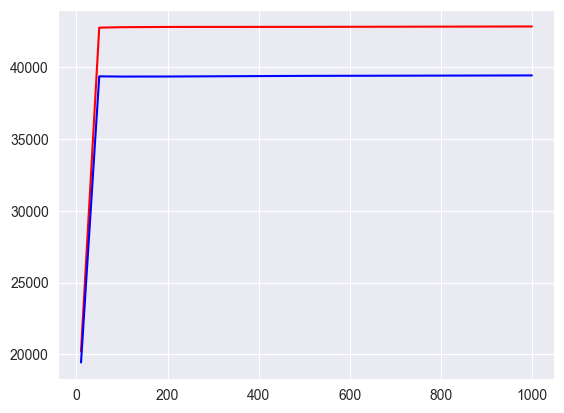

In [102]:
res_train = []
res_test = []

for max_depth in [10, 50, 100, 200, 500, 1000]:
    model = BoostingRegressorDIY(max_depth=max_depth)
    model.fit(X_train, y_train)

    res_train.append(mean_squared_error(y_train, model.predict(X_train)))
    res_test.append(mean_squared_error(y_test, model.predict(X_test)))
    
import seaborn as sns

sns.lineplot(x=[10, 50, 100, 200, 500, 1000], y=res_train, color='red')
sns.lineplot(x=[10, 50, 100, 200, 500, 1000], y=res_test, color='blue')